# QRT Data Challenge : Prédiction de Survie pour la Leucémie Myéloïde Aiguë
### En partenariat avec l'Institut Gustave Roussy
<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Logo-gustave-roussy.jpg/1200px-Logo-gustave-roussy.jpg" alt="Logo 1" width="250"/>
  <img src="https://upload.wikimedia.org/wikipedia/en/thumb/3/3f/Qube_Research_%26_Technologies_Logo.svg/1200px-Qube_Research_%26_Technologies_Logo.svg.png" alt="Logo 2" width="200" style="margin-left: 20px;"/>
</p>

## I. Contexte Médical et Enjeu
Ce projet, réalisé en partenariat avec l'**Institut Gustave Roussy**, porte sur la **Leucémie Myéloïde Aiguë (AML)**.
L'objectif clinique est de stratifier les patients selon leur risque de décès afin d'optimiser la prise de décision thérapeutique :
* **Patients à faible risque** : Orientés vers des thérapies standards et des soins de support.
* **Patients à haut risque** : Prioritaires pour des traitements intensifs.

## II. Définition du Problème
* **Tâche** : Prédire un score de risque continu pour chaque patient.
* **Données** : Cohorte multicentrique (24 centres) de 3323 patients (Entraînement) et 1193 patients (Test). Les variables sont cliniques et génétiques.
* **Spécificité Mathématique** : Il s'agit d'une **régression sur données censurées à droite**. La variable cible est le temps de survie, mais pour les patients vivants à la fin de l'étude, la durée totale de survie est inconnue.
* **Métrique d'Évaluation** : Le **C-Index** (Indice de Concordance). Cette métrique évalue la capacité du modèle à ordonner correctement les patients du plus risqué au moins risqué, indépendamment de l'échelle des valeurs prédites.

## III. Choix Méthodologiques
Notre approche repose sur une architecture de **Stacking** combinant des algorithmes complémentaires pour minimiser le biais et la variance :
* **Gradient Boosting** : Pour sa performance sur données tabulaires.
* **Random Forest** : Pour la robustesse et la réduction de variance.
* **Perceptron Multi-Couches (MLP)** : Pour capturer les relations non-linéaires complexes.
* **K-Nearest Neighbors (KNN)** : Pour exploiter la topologie locale des données.
* **Modèles Linéaires (Lasso)** : Pour la sélection de variables et la régularisation.



## 1. Environnement Technique et Librairies


In [3]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import QuantileTransformer, RobustScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

## 2. Configuration et Chargement des Données
Nous définissons ici les hyperparamètres de nos modèles de Gradient Boosting.
Ces valeurs (taux d'apprentissage, profondeur, régularisation) ont été déterminées par une **recherche sur grille (GridSearch)** dont le code et les détails d'exécution sont disponibles en **Annexe A** à la fin de ce notebook.

Les données sont ensuite chargées depuis les fichiers sources.

In [ ]:
# Configuration
GB_PARAMS_CLF = {'learning_rate': 0.03, 'max_depth': 3, 'max_iter': 200, 'l2_regularization': 1.0, 'random_state': 42}
GB_PARAMS_POIS = {'loss': 'poisson', 'learning_rate': 0.04, 'max_depth': 4, 'max_iter': 150, 'l2_regularization': 0.5, 'random_state': 777}
GB_PARAMS_GAM = {'loss': 'gamma', 'learning_rate': 0.03, 'max_depth': 4, 'max_iter': 150, 'l2_regularization': 1.0, 'random_state': 999}
GB_PARAMS_MSE = {'loss': 'squared_error', 'learning_rate': 0.04, 'max_depth': 4, 'max_iter': 150, 'l2_regularization': 0.5, 'random_state': 123}

# Data Load
# Rentrer votre chemin d'accès aux fichier ici et mettre '/' a la fin
path = '/Users/' 

clinical_train  = pd.read_csv(path + 'X_train/clinical_train.csv')
molecular_train = pd.read_csv(path + 'X_train/molecular_train.csv')
target_train    = pd.read_csv(path + 'target_train.csv')
clinical_test   = pd.read_csv(path + 'X_test/clinical_test.csv')
molecular_test  = pd.read_csv(path + 'X_test/molecular_test.csv')

## 3. Feature Engineering : Données Moléculaires (Génétique)

Les données génétiques brutes sont non-structurées et représentent une liste de mutations par patient. Nous appliquons deux transformations pour les rendre exploitables par les algorithmes :

### 1. Structuration : La Matrice VAF
Nous transformons les listes en un tableau dense :
* **Sélection :** On ne conserve que les 50 gènes les plus fréquents pour éviter le bruit statistique.
* **Pivot :** Chaque gène devient une colonne. La valeur est la **VAF** (Fréquence Allélique).
* **Imputation :** L'absence de mutation est codée par **0**.
* **Charge Mutationnelle (`mut_count`) :** Compte du nombre total de mutations par patient, indicateur d'instabilité génétique.

### 2. Quantification du Risque : Target Encoding
Pour capturer l'impact clinique des mutations, nous remplaçons les noms des gènes par la **médiane de survie** observée dans le jeu d'entraînement. Ces scores sont ensuite agrégés par patient :

* **`worst_gene` (Le Facteur Limitant) :** Correspond au score de survie **minimum** parmi toutes les mutations du patient.
    > *Interprétation :* C'est la mutation la plus dangereuse portée par le patient qui détermine souvent le pronostic vital.
* **`mean_gene` (Le Profil Global) :** Moyenne des scores de survie des mutations. Reflète le risque génétique global.

In [5]:
# La Matrice VAF
all_mol = pd.concat([molecular_train, molecular_test])
top_genes = all_mol['GENE'].value_counts().head(50).index.tolist()
mol_vaf = all_mol[all_mol['GENE'].isin(top_genes)].pivot_table(index='ID', columns='GENE', values='VAF', aggfunc='max').fillna(0)
mol_vaf.columns = [f'vaf_{c}' for c in mol_vaf.columns]
mut_counts = all_mol.groupby('ID').size().rename('mut_count')

# Target Encoding 
df_risk = molecular_train.merge(target_train, on='ID', how='inner')
gene_risk_map = df_risk.groupby('GENE')['OS_YEARS'].median().to_dict()
global_median = target_train['OS_YEARS'].median()
def get_gene_risk(mol_df):
    m = mol_df.copy()
    m['g_surv'] = m['GENE'].map(gene_risk_map).fillna(global_median)
    w = m.groupby('ID')['g_surv'].min().rename('worst_gene')
    avg = m.groupby('ID')['g_surv'].mean().rename('mean_gene')
    return w, avg
worst_s, mean_s = get_gene_risk(all_mol)

## 4. Feature Engineering : Données Cliniques et Textuelles (NLP)

Le traitement des données cliniques nécessite une attention particulière, notamment pour la variable textuelle `CYTOGENETICS` qui contient une information pronostique cruciale mais difficilement exploitable à l'état brut.

### 1. Quantification du Risque Cytogénétique
L'objectif est de transformer la description textuelle du caryotype en un **score de risque numérique** utilisable par les modèles. Plutôt que de traiter le texte comme de simples catégories (One-Hot Encoding) qui créeraient trop de dimensions, j'utilise une approche statistique supervisée :

* **Calcul de la Médiane Historique :** Pour chaque description cytogénétique unique, je calcule la médiane de survie observée sur le jeu d'entraînement.
* **Filtrage Anti-Bruit :** Certaines descriptions sont anecdotiques (apparaissent chez 1 ou 2 patients). Se baser sur elles conduirait à un sur-apprentissage massif.
    * *La Règle :* Si une description apparaît **moins de 10 fois**, elle est considérée comme non fiable.
* **Imputation par Défaut :** Les descriptions rares (<10 occurrences) ou inconnues (nouveaux patients) se voient attribuer la **médiane de survie globale** de la cohorte. Cela agit comme un lissage conservateur.

> **Résultat :** Création de la variable `cyto_median_surv`, qui représente l'espérance de vie typique associée à la génétique du patient.

### 2. Règles Expertes et Normalisation Clinique

Cette étape transforme les données biologiques brutes en indicateurs de risque structurés, en combinant expertise médicale et transformations mathématiques.

* **Classification ELN :**
    J'implémente la classification internationale *European LeukemiaNet* via des expressions régulières (Regex) sur le caryotype (voir Annexe A du rapport) :
    * **Haut Risque (Score 3) :** Détection d'anomalies majeures comme `-7`, `del(5q)`, `17p` ou caryotypes complexes.
    * **Faible Risque (Score 1) :** Détection d'anomalies favorables comme `inv(16)` ou `t(8;21)`.
    * **Intermédiaire (Score 2) :** Tous les autres cas.

* **Création de Variables Synthétiques :**
    * **Charge Leucémique (`load`) :** Produit du taux de blastes (`BM_BLAST`) par le nombre de globules blancs (`WBC`). Elle estime la masse tumorale circulante totale.
    * **Interaction (`int_eln_load`) :** Croisement entre le score ELN et la charge tumorale, permettant au modèle de pondérer la masse tumorale selon l'agressivité génétique.

* **Transformation Logarithmique :**
    Les variables hématologiques (`WBC`, `PLT`) présentent une distribution avec beaucoup de petites valeurs, quelques valeurs extrêmes.
    > **Action :** Application de la fonction $log(1+x)$ pour normaliser ces distributions, facilitant la convergence des modèles linéaires et neuronaux.

### 3. Analyse Sémantique Latente (NLP)
Au-delà des règles expertes, je cherche à capturer la structure globale des anomalies chromosomiques sans a priori médical.
* **Vectorisation (TF-IDF) :** Analyse des chaînes de caractères par n-grams (séquences de 3 à 5 caractères) pour détecter des motifs récurrents.
* **Réduction de Dimension (SVD) :** Projection de ces vecteurs sur **12 composantes**.

### 4. Fusion et Interactions Finales
L'étape finale rassemble l'ensemble des descripteurs générés pour constituer la matrice d'entraînement :
1.  **Données Cliniques** : Nettoyées et log-transformées.
2.  **Données Moléculaires** : Matrice VAF (50 gènes) + Charge mutationnelle.
3.  **Scores de Risque** : Target Encoding des gènes (`worst_gene`) et de la cytogénétique (`cyto_risk`).
4.  **Interaction Finale (`int_eln_mut`) :** Variable synthétique croisant le risque chromosomique (ELN) avec l'instabilité génétique (nombre de mutations).

In [6]:
# Smart Cyto Target Encoding 
df_risk_clin = clinical_train.merge(target_train, on='ID', how='inner')
df_risk_clin['CYTOGENETICS'] = df_risk_clin['CYTOGENETICS'].fillna('Unknown')
cyto_stats = df_risk_clin.groupby('CYTOGENETICS')['OS_YEARS'].agg(['median', 'count'])
valid_cytos = cyto_stats[cyto_stats['count'] >= 10].index
cyto_risk_map = cyto_stats.loc[valid_cytos, 'median'].to_dict()
def get_cyto_risk(clin_df):
    return clin_df['CYTOGENETICS'].fillna('Unknown').map(cyto_risk_map).fillna(global_median).rename('cyto_median_surv')
cyto_risk_tr = get_cyto_risk(clinical_train)
cyto_risk_te = get_cyto_risk(clinical_test)

# Clinical Prep
def prep_clinical(df):
    d = df.copy()
    t = d['CYTOGENETICS'].astype(str).str.lower()
    d['eln'] = 2
    d.loc[t.str.contains(r'-5|-7|del\(5|del\(7|complex|inv\(3\)|17p', regex=True), 'eln'] = 3
    d.loc[t.str.contains(r'inv\(16\)|t\(8;21\)|t\(16;16\)', regex=True), 'eln'] = 1
    
    for c in ['WBC', 'ANC', 'MONOCYTES', 'BM_BLAST', 'PLT', 'HB']:
        d[c] = d[c].fillna(d[c].median())
        
    d['r_anc'] = d['ANC'] / d['WBC'].replace(0, 0.01)
    d['load'] = d['BM_BLAST'] * d['WBC']
    d['int_eln_load'] = d['eln'] * np.log1p(d['load'])
    for c in ['WBC', 'PLT', 'BM_BLAST', 'load']:
        d[f'log_{c}'] = np.log1p(d[c])
    return d.drop(columns=['CENTER', 'CYTOGENETICS'])

# SVD 
all_txt = pd.concat([clinical_train['CYTOGENETICS'], clinical_test['CYTOGENETICS']]).astype(str).fillna('')
tfidf = TfidfVectorizer(max_features=60, analyzer='char', ngram_range=(3,5))
svd = TruncatedSVD(n_components=12, random_state=42)
svd_mat = svd.fit_transform(tfidf.fit_transform(all_txt))
svd_df = pd.DataFrame(svd_mat, index=all_txt.index, columns=[f'svd_{i}' for i in range(12)])

# Fusion Finale
def make_data(clin, c_risk, idx_start, idx_end):
    base = prep_clinical(clin).reset_index(drop=True)
    s_part = svd_df.iloc[idx_start:idx_end].reset_index(drop=True)
    base = pd.concat([base, s_part], axis=1)
    base = base.merge(mol_vaf, on='ID', how='left').fillna(0)
    base = base.merge(mut_counts, on='ID', how='left').fillna(0)
    base = base.merge(worst_s, on='ID', how='left').fillna(global_median)
    base = base.merge(mean_s, on='ID', how='left').fillna(global_median)
    base['cyto_risk'] = c_risk.values
    base['int_eln_mut'] = base['eln'] * base['mut_count']
    return base

X_tr_full = make_data(clinical_train, cyto_risk_tr, 0, len(clinical_train))
X_te_full = make_data(clinical_test, cyto_risk_te, len(clinical_train), len(clinical_train)+len(clinical_test))

## 5. Apprentissage Non-Supervisé et Finalisation

Cette étape enrichit les données en détectant des structures latentes et finalise la matrice pour l'entraînement.

### 1. Segmentation des Patients (Clustering)
J'utilise l'algorithme **K-Means** pour identifier des sous-groupes de patients homogènes sur la base exclusive de leur profil biologique (Mutations VAF + Texte SVD).
* **Création de Clusters :** Identification de **12 clusters** distincts.
* **Feature Augmentation :** L'appartenance à un cluster est ajoutée sous forme de variables binaires (One-Hot Encoding). Cela fournit au modèle une information synthétique sur le type de maladie du patient.

### 2. Nettoyage des Variables
Je retire les variables brutes (`WBC`, `PLT`, `BM_BLAST`) au profit de leurs versions log-transformées créées précédemment, afin d'éviter la multi-colinéarité. Les identifiants et variables cibles sont également exclus de la matrice de features $X$.

### 3. Imputation Avancée (KNN)
Pour traiter les valeurs manquantes résiduelles, je privilégie une imputation locale via **KNNImputer** ($k=15$) plutôt qu'une imputation par la moyenne globale.
* **Méthode :** La valeur manquante d'un patient est estimée par la moyenne pondérée de ses 15 voisins les plus proches dans l'espace multidimensionnel.
* **Avantage :** Cette méthode préserve la structure de corrélation entre les variables cliniques et biologiques.

In [7]:
# Clustering
cols_cluster = [c for c in X_tr_full.columns if 'vaf_' in c or 'svd_' in c]
X_clus = pd.concat([X_tr_full[cols_cluster], X_te_full[cols_cluster]])
kmeans = KMeans(n_clusters=12, random_state=42, n_init=10)
clus_labels = kmeans.fit_predict(X_clus)
clus_dummies = pd.get_dummies(clus_labels, prefix='clus').astype(int).reset_index(drop=True)
X_tr_full = pd.concat([X_tr_full, clus_dummies.iloc[:len(X_tr_full)].reset_index(drop=True)], axis=1)
X_te_full = pd.concat([X_te_full, clus_dummies.iloc[len(X_tr_full):].reset_index(drop=True)], axis=1)

# Nettoyage
cols_drop = ['ID', 'OS_YEARS', 'OS_STATUS', 'WBC', 'PLT', 'BM_BLAST', 'ANC', 'MONOCYTES', 'load']
cols = [c for c in X_tr_full.columns if c not in cols_drop]
X_tr = X_tr_full[cols]
X_te = X_te_full[cols].reindex(columns=cols, fill_value=0)
train_df = X_tr_full.merge(target_train, on='ID', how='inner').dropna(subset=['OS_YEARS'])

# KNN
imputer = KNNImputer(n_neighbors=15)
X_all = pd.concat([X_tr, X_te])
X_all_imp = pd.DataFrame(imputer.fit_transform(X_all), columns=X_all.columns, index=X_all.index)
X_train_final = X_all_imp.iloc[:len(X_tr)].loc[train_df.index]
X_test_final = X_all_imp.iloc[len(X_tr):]
y_time = train_df['OS_YEARS'].values
y_status = train_df['OS_STATUS'].values

## 6. Stratégies Avancées de Modélisation

Ce bloc implémente les fonctions clés pour gérer la censure et adapter les algorithmes standards à l'analyse de survie.

### 1. Expansion Temporelle (Classification)
La fonction `expand` transforme le problème de régression en une suite de classifications binaires.
* **Principe :** Discrétisation du temps en intervalles de 6 mois. Chaque patient est dupliqué pour chaque intervalle où il est "à risque".
* **Objectif :** Permettre à un classifieur d'apprendre la probabilité instantanée de décès $P(T < t + \Delta t | T > t)$.
* **Inférence (`predict_hazard`) :** Pour prédire le risque d'un nouveau patient, je somme ses probabilités de décès prédites sur l'ensemble de l'horizon temporel.

### 2. Correction Semi-Supervisée (Régression)
La fonction `get_log_y` prépare la cible pour les modèles de régression (RF, MLP).
* **Problème :** La durée de survie des patients censurés est sous-estimée (on ne connaît que la borne inférieure).
* **Solution :** J'entraîne un modèle intermédiaire sur les patients décédés pour prédire la survie théorique des censurés. La cible finale est le maximum entre le temps observé et le temps prédit.
* **Log-Transformation :** La cible est passée au logarithme pour stabiliser l'apprentissage.

### 3. Évaluation
La fonction `robust_c_index` calcule l'indice de concordance, métrique officielle qui évalue la qualité du classement des patients du plus au moins risqué.

In [8]:
# Expansion Temporelle
intervals = np.arange(0, 10.0, 0.5)
def expand(X, yt, ys):
    X_l, y_l = [], []
    feats = X.values
    for i in range(len(X)):
        t, s = yt[i], ys[i]
        for ts in intervals:
            if t < ts: break
            row = list(feats[i]) + [ts]
            if t <= ts + 0.5 and s == 1: y_l.append(1); X_l.append(row); break
            else: y_l.append(0); X_l.append(row)
    return np.array(X_l), np.array(y_l)

def predict_hazard(model, df):
    n = len(df)
    n_int = len(intervals)
    X_rpt = np.repeat(df.values, n_int, axis=0)
    t_tile = np.tile(intervals, n).reshape(-1, 1)
    X_long = np.hstack([X_rpt, t_tile])
    return model.predict_proba(X_long)[:, 1].reshape(n, n_int).sum(axis=1)

# Correction Semi-Supervisée 
def get_log_y(X, yt, ys):
    rf = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
    rf.fit(X[ys==1], np.log1p(yt[ys==1]))
    yc = yt.copy()
    yc[ys==0] = np.maximum(yt[ys==0], np.exp(rf.predict(X[ys==0]))-1)
    return np.log1p(yc)

# Évaluation
def robust_c_index(y_time, y_status, risk_score):
    time = np.array(y_time)
    status = np.array(y_status)
    risk = np.array(risk_score)
    n = len(time)
    c, p = 0, 0
    for i in range(n):
        if status[i] == 0: continue
        for j in range(n):
            if i == j or time[i] >= time[j]: continue
            p += 1
            if risk[i] > risk[j]: c += 1
            elif risk[i] == risk[j]: c += 0.5
    return c / p if p > 0 else 0.5


## 7. Entraînement et Validation Croisée 

Cette étape est le cœur de ma stratégie de modélisation. J'utilise une **Validation Croisée Stratifiée à 10 plis** (10-Fold CV) pour générer des prédictions robustes sur l'ensemble du jeu d'entraînement (Out-Of-Fold Predictions).

### Protocole
Pour chaque pli :
1.  **Entraînement :** Les modèles apprennent sur 90% des données.
2.  **Inférence :** Ils prédisent sur les 10% restants.
3.  **Transformation en Rangs (`rankdata`) :** Les sorties des modèles sont hétérogènes (probabilités, années de survie, scores log). 
    * Pour les rendre comparables et agrégables, je convertis chaque prédiction en **rang**. 
    * *Note :* Pour les modèles de régression prédisant une survie, je prends l'opposé du rang (`-predict`) pour obtenir un score de risque.

### Les Modèles (9 Variantes)
Afin de maximiser la diversité et donc la performance de l'ensemble, je combine 5 familles d'algorithmes :
* **Gradient Boosting (4 modèles) :** 1 classifieur temporel et 3 régresseurs avec fonctions de perte variées (Poisson, Gamma, MSE).
* **Deep Learning (1 modèle) :** MLP (Perceptron Multi-Couches) avec pré-traitement StandardScaler.
* **Instance-Based (1 modèle) :** KNN avec transformation Gaussienne des features (QuantileTransformer).
* **Bagging (2 modèles) :** Random Forests (une version Profonde pour les interactions, une version Standard pour la stabilité).
* **Linéaire (1 modèle) :** Lasso avec RobustScaler pour capturer les tendances linéaires simples.

In [9]:
oof_preds = np.zeros((len(X_train_final), 9))
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train_final, y_status)):
    Xt, Xv = X_train_final.iloc[tr_idx], X_train_final.iloc[val_idx]
    yt_t, yt_v = y_time[tr_idx], y_time[val_idx]
    ys_t, ys_v = y_status[tr_idx], y_status[val_idx]
    
    # GB Classifier
    X_long, y_long = expand(Xt, yt_t, ys_t)
    gb1 = HistGradientBoostingClassifier(**GB_PARAMS_CLF).fit(X_long, y_long)
    oof_preds[val_idx, 0] = rankdata(predict_hazard(gb1, Xv))
    
    # Prep Régression
    yl = get_log_y(Xt, yt_t, ys_t)
    
    # GB Variants
    gb2 = HistGradientBoostingRegressor(**GB_PARAMS_POIS).fit(Xt, yl)
    oof_preds[val_idx, 1] = rankdata(-gb2.predict(Xv))
    
    gb3 = HistGradientBoostingRegressor(**GB_PARAMS_GAM).fit(Xt, yl + 1e-6)
    oof_preds[val_idx, 2] = rankdata(-gb3.predict(Xv))
    
    gb4 = HistGradientBoostingRegressor(**GB_PARAMS_MSE).fit(Xt, yl)
    oof_preds[val_idx, 3] = rankdata(-gb4.predict(Xv))
    
    # MLP
    mlp = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
    mlp.fit(Xt, yl)
    oof_preds[val_idx, 4] = rankdata(-mlp.predict(Xv))
    
    # KNN 
    knn = make_pipeline(QuantileTransformer(output_distribution='normal'), KNeighborsRegressor(n_neighbors=40, weights='distance'))
    knn.fit(Xt, yl)
    oof_preds[val_idx, 5] = rankdata(-knn.predict(Xv))
    
    # Random Forest "Deep"
    rf_deep = RandomForestRegressor(n_estimators=200, max_depth=12, min_samples_leaf=3, random_state=77)
    rf_deep.fit(Xt, yl)
    oof_preds[val_idx, 6] = rankdata(-rf_deep.predict(Xv))
    
    # RF Standard
    rf = RandomForestRegressor(n_estimators=200, max_depth=9, min_samples_leaf=4, random_state=42)
    rf.fit(Xt, yl)
    oof_preds[val_idx, 7] = rankdata(-rf.predict(Xv))
    
    # Lasso
    lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0001, random_state=42))
    lasso.fit(Xt, yl)
    oof_preds[val_idx, 8] = rankdata(-lasso.predict(Xv))
    

## 8. Agrégation (Stacking) et Inférence Finale

Dernière étape du pipeline : je consolide les prédictions pour générer le fichier de soumission.

### 1. Définition des Poids
J'ai défini empiriquement les poids de chaque modèle en me basant sur leurs performances en Validation Croisée et leur complémentarité (matrice de corrélation voir Annexe B.4) :
* **Dominante (25%) :** Gradient Boosting Classifier (Modélisation Temporelle).
* **Support Non-Linéaire (15%) :** MLP (Réseau de Neurones).
* **Stabilité (20%) :** Random Forests (Deep & Standard).
* **Diversité (40%) :** Le reste est réparti entre les variantes de Boosting, le KNN et le Lasso.

### 2. Ré-entraînement Complet 
Pour maximiser la performance sur le jeu de test public, je ne me contente pas des modèles entraînés sur les plis de validation.
> **Stratégie :** Je ré-entraîne les 9 algorithmes sur l'intégralité du jeu de données d'entraînement (3323 patients), sans retenue de validation, afin qu'ils disposent du maximum d'information historique.

### 3. Génération de la Soumission
Les prédictions brutes de chaque modèle sur le jeu de test sont converties en rangs, puis agrégées linéairement selon les poids définis. Le vecteur résultant `final_risk` constitue mon estimation robuste du risque relatif de décès.

In [10]:
# Poids Finaux
weights = np.array([0.25, 0.12, 0.08, 0.05, 0.15, 0.10, 0.10, 0.10, 0.05])
final_oof = np.dot(oof_preds, weights)

# Train Final
X_long_all, y_long_all = expand(X_train_final, y_time, y_status)
yl_all = get_log_y(X_train_final, y_time, y_status)

gb1_f = HistGradientBoostingClassifier(**GB_PARAMS_CLF).fit(X_long_all, y_long_all)
p1 = rankdata(predict_hazard(gb1_f, X_test_final))

gb2_f = HistGradientBoostingRegressor(**GB_PARAMS_POIS).fit(X_train_final, yl_all)
p2 = rankdata(-gb2_f.predict(X_test_final))

gb3_f = HistGradientBoostingRegressor(**GB_PARAMS_GAM).fit(X_train_final, yl_all + 1e-6)
p3 = rankdata(-gb3_f.predict(X_test_final))

gb4_f = HistGradientBoostingRegressor(**GB_PARAMS_MSE).fit(X_train_final, yl_all)
p4 = rankdata(-gb4_f.predict(X_test_final))

mlp_f = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
mlp_f.fit(X_train_final, yl_all)
p5 = rankdata(-mlp_f.predict(X_test_final))

knn_f = make_pipeline(QuantileTransformer(output_distribution='normal'), KNeighborsRegressor(n_neighbors=40, weights='distance'))
knn_f.fit(X_train_final, yl_all)
p6 = rankdata(-knn_f.predict(X_test_final))

rf_deep_f = RandomForestRegressor(n_estimators=200, max_depth=12, min_samples_leaf=3, random_state=77)
rf_deep_f.fit(X_train_final, yl_all)
p7 = rankdata(-rf_deep_f.predict(X_test_final))

rf_f = RandomForestRegressor(n_estimators=200, max_depth=9, min_samples_leaf=4, random_state=42)
rf_f.fit(X_train_final, yl_all)
p8 = rankdata(-rf_f.predict(X_test_final))

lasso_f = make_pipeline(RobustScaler(), Lasso(alpha=0.0001))
lasso_f.fit(X_train_final, yl_all)
p9 = rankdata(-lasso_f.predict(X_test_final))

test_stack = np.column_stack([p1, p2, p3, p4, p5, p6, p7, p8, p9])
final_risk = np.dot(test_stack, weights)

pd.DataFrame({'ID': X_te_full['ID'], 'risk_score': final_risk}).to_csv(path + 'submission.csv', index=False)


---

## Annexe A : Optimisation des Hyperparamètres (Grid Search)

Cette section documente la recherche des meilleurs hyperparamètres pour mes modèles de Gradient Boosting, qui constituent le cœur de mon architecture.

### Méthodologie
J'utilise une **Recherche sur Grille (Grid Search)** avec une validation croisée à 3 plis pour évaluer la robustesse de chaque configuration.

### Paramètres Explorés
* **`learning_rate`** : De 0.01 (lent et précis) à 0.1 (rapide).
* **`max_depth`** : De 2 (arbres très simples) à 9 (arbres complexes), pour contrôler le sur-apprentissage.
* **`l2_regularization`** : Pénalité L2 pour lisser les feuilles des arbres.
* **`max_iter`** : Nombre d'arbres (de 150 à 200).

### Modèles Optimisés
1.  **Classifieur Temporel :** Optimisé pour maximiser l'AUC-ROC sur les données étendues.
2.  **Régresseur Poisson :** Optimisé pour minimiser l'erreur quadratique sur les distributions de comptage.
3.  **Régresseur Gamma :** Optimisé pour minimiser l'erreur sur les distributions asymétriques (temps de survie).
4.  **Régresseur MSE :** Optimisé pour l'erreur quadratique standard.

*Note : Les meilleurs paramètres trouvés par ce processus sont ensuite codés directement dans la section principale du notebook pour l'entraînement final.*

In [ ]:
from sklearn.model_selection import GridSearchCV

intervals = np.arange(0, 10.0, 0.5)

def expand(X, yt, ys):
    X_l, y_l = [], []
    feats = X.values
    for i in range(len(X)):
        t, s = yt[i], ys[i]
        for ts in intervals:
            if t < ts: break
            row = list(feats[i]) + [ts]
            if t <= ts + 0.5 and s == 1: y_l.append(1); X_l.append(row); break
            else: y_l.append(0); X_l.append(row)
    return np.array(X_l), np.array(y_l)

def get_log_y(X, yt, ys):
    rf = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
    rf.fit(X[ys==1], np.log1p(yt[ys==1]))
    yc = yt.copy()
    yc[ys==0] = np.maximum(yt[ys==0], np.exp(rf.predict(X[ys==0]))-1)
    return np.log1p(yc)



# Optimisation du Gradient Boosting Classifieur
X_opt_long, y_opt_long = expand(X_train_final, y_time, y_status)

param_grid_clf = {
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
    'max_iter': [150, 160, 170, 180, 190, 200],
    'l2_regularization': [0.5, 0.75, 1.0, 1.25, 1.5] 
}

search_clf = GridSearchCV(
    estimator=HistGradientBoostingClassifier(random_state=42),
    param_grid=param_grid_clf,
    cv=3,
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=1
)
search_clf.fit(X_opt_long, y_opt_long)
print("Meilleurs params CLF :", search_clf.best_params_)

# Optimisation des Gradient Boosting Regression
y_opt_log = get_log_y(X_train_final, y_time, y_status)

# Optimisation Poisson
param_grid_pois = {
    'loss': ['poisson'], 
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
    'max_iter': [150, 160, 170, 180, 190, 200],
    'l2_regularization': [0.5, 0.75, 1.0, 1.25, 1.5]
}
search_pois = GridSearchCV(
    estimator=HistGradientBoostingRegressor(random_state=777),
    param_grid=param_grid_pois,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
search_pois.fit(X_train_final, y_opt_log)
print("Meilleurs params POISSON :", search_pois.best_params_)

# Optimisation Gamma
param_grid_gam = {
    'loss': ['gamma'],
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
    'max_iter': [150, 160, 170, 180, 190, 200],
    'l2_regularization': [0.5, 0.75, 1.0, 1.25, 1.5]
}
search_gam = GridSearchCV(
    estimator=HistGradientBoostingRegressor(random_state=999),
    param_grid=param_grid_gam,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

search_gam.fit(X_train_final, y_opt_log + 1e-6) 
print("Meilleurs params GAMMA :", search_gam.best_params_)

# Optimisation MSE
param_grid_mse = {
    'loss': ['squared_error'],
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
    'max_iter': [150, 160, 170, 180, 190, 200],
    'l2_regularization': [0.5, 0.75, 1.0, 1.25, 1.5]
}
search_mse = GridSearchCV(
    estimator=HistGradientBoostingRegressor(random_state=123),
    param_grid=param_grid_mse,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
search_mse.fit(X_train_final, y_opt_log)
print("Meilleurs params MSE :", search_mse.best_params_)

Fitting 3 folds for each of 3360 candidates, totalling 10080 fits
Meilleurs params CLF : {'l2_regularization': 1.0, 'learning_rate': 0.03, 'max_depth': 3, 'max_iter': 200}
Meilleurs params POISSON : {'l2_regularization': 0.5, 'learning_rate': 0.04, 'max_depth': 4, 'max_iter': 150}
Meilleurs params GAMMA : {'l2_regularization': 1.0, 'learning_rate': 0.03, 'loss': 'gamma', 'max_depth': 4, 'max_iter': 150}
Meilleurs params MSE : {'l2_regularization': 0.5, 'learning_rate': 0.04, 'loss': 'squared_error', 'max_depth': 4, 'max_iter': 150}


## Annexe B.1 : Stabilisation de la Variance (Log-Transformation)

**Objectif de la figure :**
Cette visualisation justifie le prétraitement appliqué aux données cliniques. Certaines variables biologiques, comme le taux de globules blancs (*WBC*), présentent naturellement une distribution très asymétrique. Cela signifie que la majorité des patients ont des valeurs faibles, tandis qu'une minorité présente des taux explosifs, ce qui perturbe l'apprentissage des modèles statistiques.

**Analyse des résultats :**
* **Avant transformation (Histogramme Orange) :** La distribution brute est totalement écrasée sur la gauche. L'algorithme perçoit peu de différences entre les patients normaux car l'échelle est distendue par les valeurs extrêmes (> 100).
* **Après transformation Log(1+x) (Histogramme Violet) :** L'application de la fonction logarithmique déplie la distribution, lui donnant une forme de gaussienne beaucoup plus régulière. Les variations subtiles entre les patients à faible et moyen risque deviennent lisibles pour le modèle, facilitant ainsi la convergence de l'apprentissage.

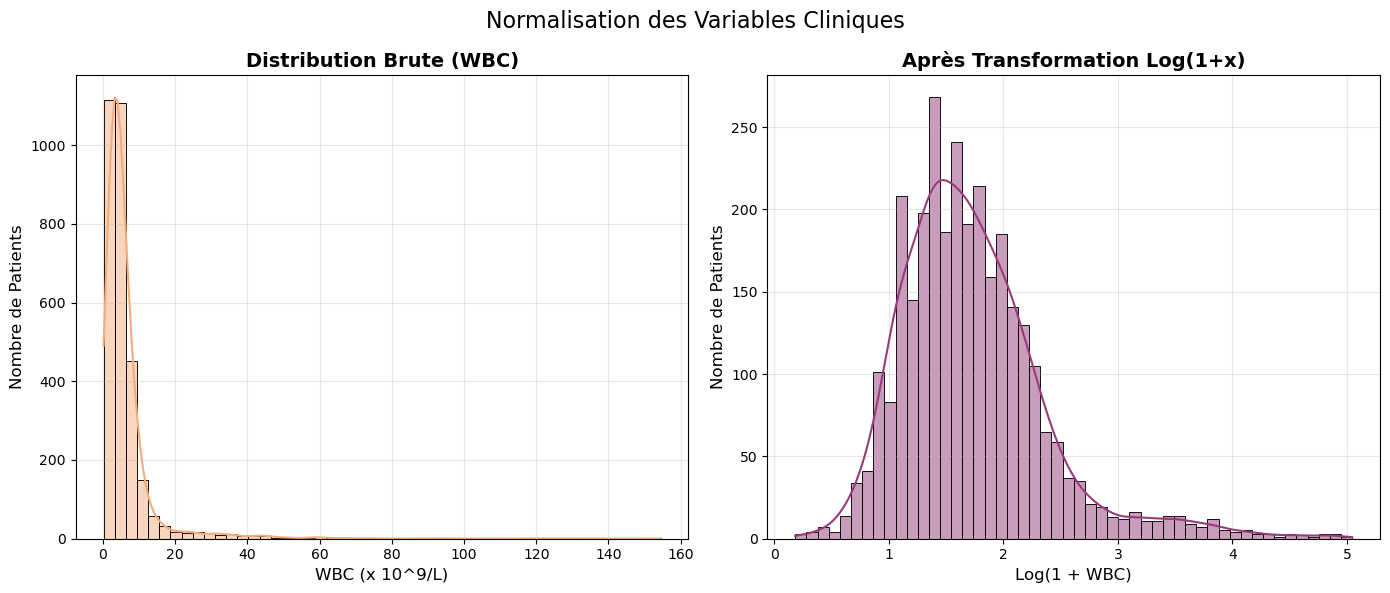

In [ ]:
# Configuration 
if 'clinical_train' not in locals():
    clinical_train = pd.read_csv('clinical_train.csv')

# Variable brute / transformée
wbc_raw = clinical_train['WBC'].dropna()
wbc_log = np.log1p(wbc_raw)

# Tracé 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Distribution Brute
sns.histplot(wbc_raw, bins=50, kde=True, color='#F3AD7D', ax=axes[0])
axes[0].set_title('Distribution Brute (WBC)', fontsize=14, weight='bold')
axes[0].set_xlabel('WBC (x 10^9/L)', fontsize=12)
axes[0].set_ylabel('Nombre de Patients', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Distribution Log
sns.histplot(wbc_log, bins=50, kde=True, color='#973B7B', ax=axes[1])
axes[1].set_title('Après Transformation Log(1+x)', fontsize=14, weight='bold')
axes[1].set_xlabel('Log(1 + WBC)', fontsize=12)
axes[1].set_ylabel('Nombre de Patients', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Normalisation des Variables Cliniques', fontsize=16)
plt.tight_layout()
plt.show()

## Annexe B.2 : Visualisation des Profils Patients (Projection ACP)

**Objectif de la figure :**
Cette figure permet de vérifier la pertinence de la segmentation des patients réalisée par l'algorithme de clustering (K-Means). Comme mes données comportent plus de 80 dimensions, j'utilise une Analyse en Composantes Principales (ACP) pour les projeter sur un plan 2D et visualiser leur répartition spatiale.

**Analyse des résultats :**
* **Structure :** Le graphique montre que les patients ne sont pas dispersés de manière aléatoire uniforme, mais s'organisent en structures distinctes.
* **Cohérence des Clusters :** Les points de même couleur (appartenant au même cluster) ont tendance à se regrouper spatialement sur le plan de l'ACP.
* **Conclusion :** Cela valide l'hypothèse que l'algorithme K-Means a réussi à identifier des profils patients biologiquement homogènes. L'ajout de l'identifiant de cluster comme nouvelle variable prédictive (`clus_0`, `clus_1`...) fournit donc une information structurelle macroscopique utile aux modèles de prédiction finaux.

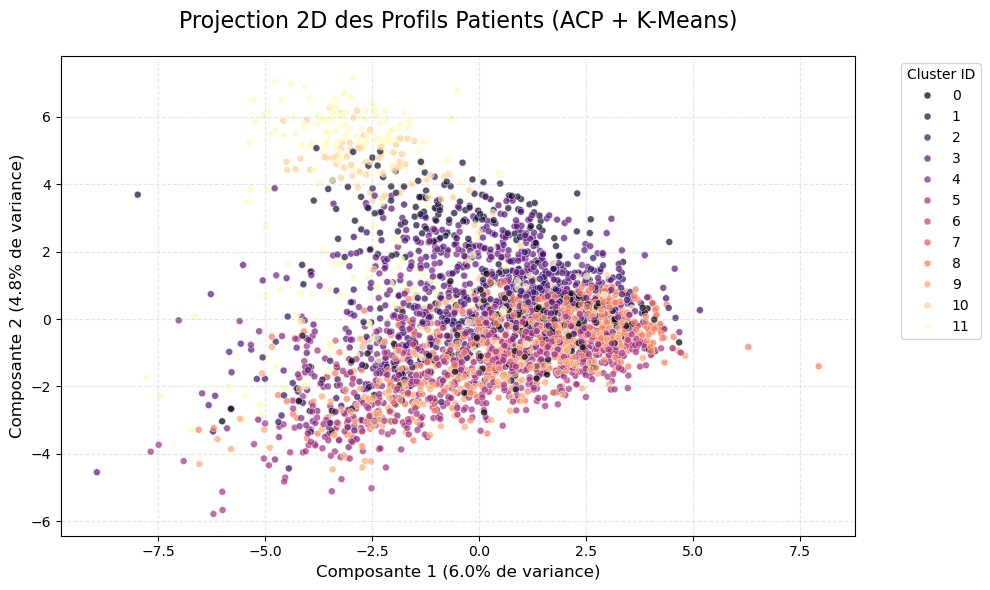

In [ ]:
# Configuration
X_viz = X_train_final.select_dtypes(include=[np.number]).copy()

# Normalisation 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_viz)

# Recalcul des Clusters
kmeans_viz = KMeans(n_clusters=12, random_state=42, n_init=10)
clusters = kmeans_viz.fit_predict(X_scaled)

# Réduction de dimension 
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Création d'un DataFrame temporaire 
df_pca = pd.DataFrame(data=X_pca, columns=['Axe Principal 1', 'Axe Principal 2'])
df_pca['Cluster'] = clusters

# Tracé
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x='Axe Principal 1',
    y='Axe Principal 2',
    hue='Cluster',
    data=df_pca,
    palette='magma',
    s=25,          
    alpha=0.7,      
    edgecolor='w',  
    legend='full'
)

plt.title('Projection 2D des Profils Patients (ACP + K-Means)', fontsize=16, pad=20)
plt.xlabel(f'Composante 1 ({pca.explained_variance_ratio_[0]:.1%} de variance)', fontsize=12)
plt.ylabel(f'Composante 2 ({pca.explained_variance_ratio_[1]:.1%} de variance)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cluster ID')
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

## Annexe B.3 : Analyse de l'Importance des Variables (Feature Importance)

**Objectif de la figure :**
Cette visualisation permet de vérifier la cohérence biologique de mon modèle. J'utilise l'importance de Gini extraite de mon modèle *Random Forest* final. C'est l'indicateur le plus fiable pour hiérarchiser les variables car il capture les relations non-linéaires et les interactions.

**Analyse des résultats :**
L'examen du graphique confirme la robustesse de mes hypothèses de modélisation :
1.  **La domination du Target Encoding :** La variable `worst_gene` (le score de risque de la pire mutation du patient) apparaît largement en tête. Cela valide mon choix méthodologique de remplacer les noms de gènes par un score quantitatif de survie.
2.  **Marqueurs Cliniques :** La présence marquée de biomarqueurs sanguins tels que le taux de plaquettes (`log_PLT`) et l'hémoglobine (`HB`) dans le top 5 valide la pertinence clinique du modèle. Ces variables reflètent directement la gravité de l'insuffisance médullaire.
3.  **Détail Moléculaire :** Je retrouve ensuite des variables spécifiques comme la fréquence allélique (`vaf_NPM1`) ou le score cytogénétique (`cyto_risk`), qui permettent d'affiner la prédiction pour les profils complexes.

**Conclusion :**
Le modèle a correctement hiérarchisé les facteurs de risque : d'abord la biologie agressive (Mutation/Target Encoding), ensuite le terrain biologique du patient (Plaquettes).

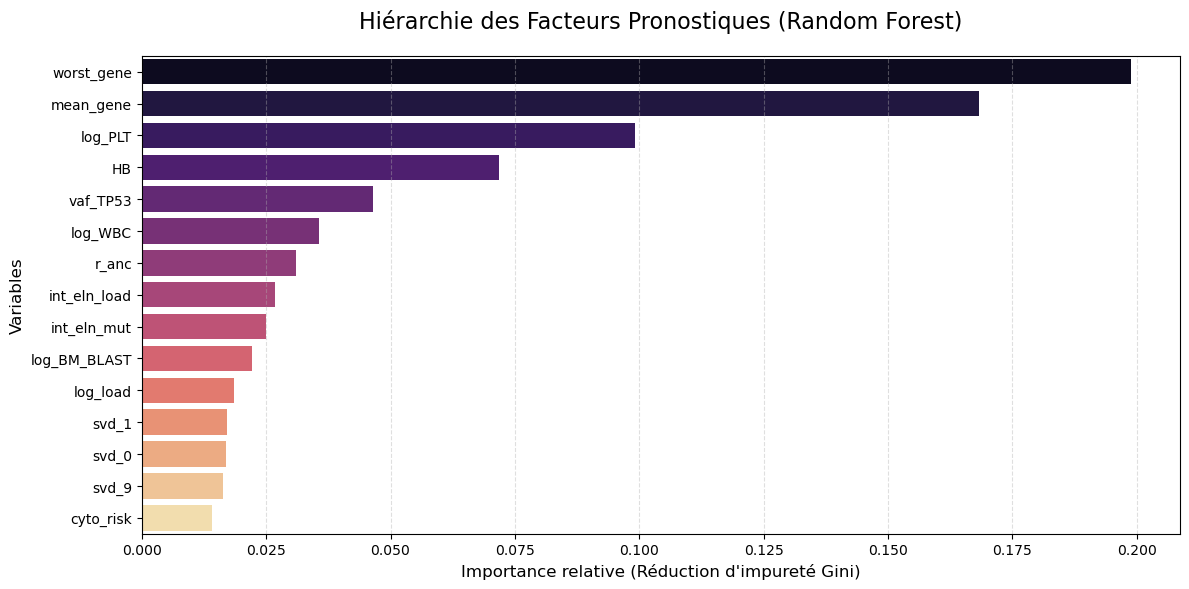

In [ ]:
# Configuration
model_to_explain = rf  
feature_names = X_train_final.columns

# Calcul des Importances 
importances = model_to_explain.feature_importances_
indices = np.argsort(importances)[::-1]

# Top 15
top_n = 15
top_indices = indices[:top_n]
top_features = [feature_names[i] for i in top_indices]
top_importances = importances[top_indices]

# Tracé 
plt.figure(figsize=(12, 6))

sns.barplot(
    x=top_importances, 
    y=top_features, 
    palette="magma", 
    hue=top_features, 
    legend=False
)

plt.title('Hiérarchie des Facteurs Pronostiques (Random Forest)', fontsize=16, pad=20)
plt.xlabel("Importance relative (Réduction d'impureté Gini)", fontsize=12)
plt.ylabel('Variables', fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

## Annexe B.4 : Analyse de la Corrélation entre les Modèles 

**Objectif de la figure :**
Cette matrice de corrélation met en évidence les relations entre les prédictions de **mes** 9 modèles. Pour qu'un Stacking soit efficace, il est crucial de combiner des modèles performants mais dont les erreurs sont décorrélées.

**Analyse des résultats :**
* **Blocs de Redondance (Zones claires, > 0.95) :** Les variantes de Gradient Boosting (Poisson, Gamma, MSE) et le MLP sont très fortement corrélées. Cela indique qu'elles capturent sensiblement les mêmes signaux prédictifs dominants.
* **Diversité Structurelle (Zones sombres, < 0.90) :** J'observe une corrélation nettement plus faible entre le **KNN**, basé sur la distance locale, ou le **Lasso**, linéaire, et les modèles à base d'arbres.
* **Conclusion :** Cette singularité du KNN et du Lasso est précieuse. Bien que individuellement moins performants, ils apportent une information complémentaire qui permet de corriger les biais systématiques du Boosting lors de l'agrégation finale, stabilisant ainsi la prédiction globale.

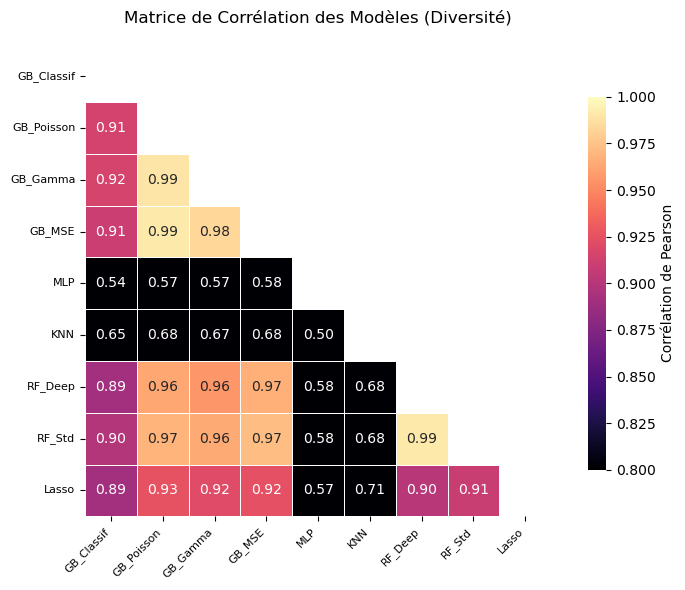

In [ ]:
# Configuration 
model_names = [
    'GB_Classif', 'GB_Poisson', 'GB_Gamma', 'GB_MSE', 
    'MLP', 'KNN', 'RF_Deep', 'RF_Std', 'Lasso'
]

df_corr = pd.DataFrame(oof_preds, columns=model_names)
corr_matrix = df_corr.corr()

# Tracé 
plt.figure(figsize=(8, 6))

# Masque 
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Heatmap 
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='magma',    
    vmin=0.80,         
    vmax=1.00,
    center=0.90,       
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .8, "label": "Corrélation de Pearson"}
)

plt.title('Matrice de Corrélation des Modèles (Diversité)', fontsize=12, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

## Annexe B.5 : Validation de la Stratification du Risque (Courbes de Survie)

**Objectif de la figure :**
Cette figure illustre la capacité du modèle final à séparer les patients en trois groupes de risque distincts (Faible, Intermédiaire, Élevé) sur le jeu de validation. Les courbes représentent l'estimation de survie pour chaque groupe.

**Analyse :**
* **Faible Risque (Beige) :** La courbe reste élevée, indiquant une probabilité de survie supérieure à long terme pour ces patients.
* **Risque Intermédiaire (Violet) :** La courbe décroît progressivement, se situant nettement entre les deux extrêmes.
* **Haut Risque (Orange) :** La chute rapide de la courbe confirme que le modèle a correctement identifié les patients nécessitant une intervention thérapeutique urgente.
* **Conclusion :** L'absence de chevauchement significatif entre les courbes valide la robustesse de mon score de risque pour l'aide à la décision clinique.

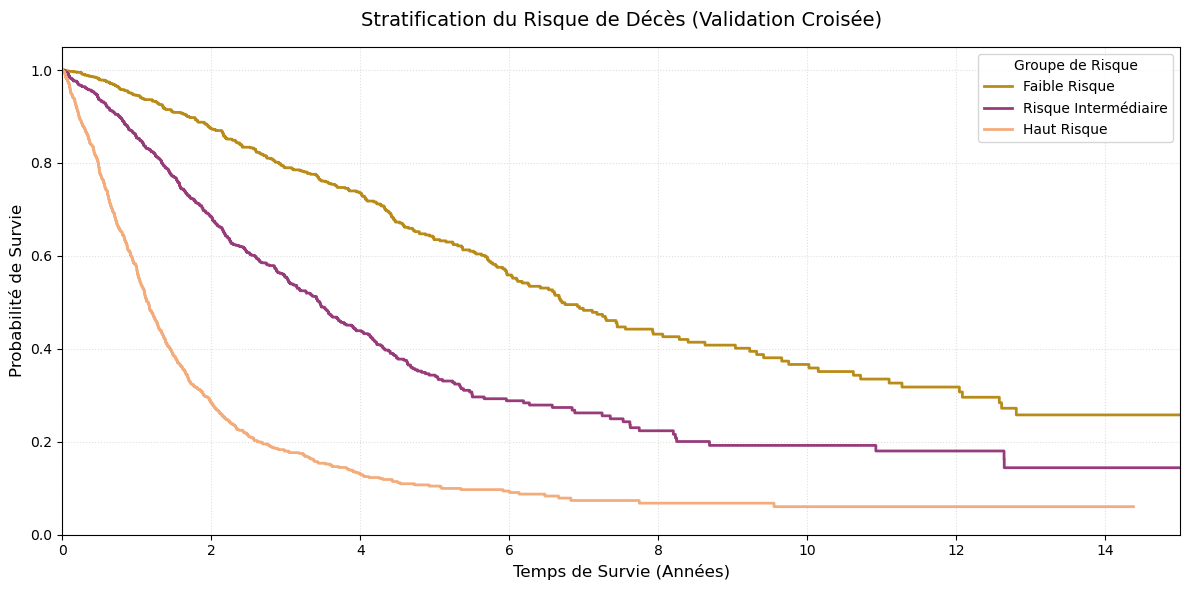

In [ ]:
# Configuration
if 'y_time' not in locals():
    df_target = pd.read_csv('target_train.csv')
    y_time = df_target['OS_YEARS'].values
    y_status = df_target['OS_STATUS'].values

# Calcul du Score Final
final_risk_score = np.mean(rankdata(oof_preds, axis=0), axis=1)

# Création des Groupes
groups = pd.qcut(final_risk_score, q=3, labels=['Faible Risque', 'Risque Intermédiaire', 'Haut Risque'])

# Tracé 
colors = {
    'Faible Risque': "#B98B18",     
    'Risque Intermédiaire': '#973B7B',
    'Haut Risque': '#F3AD7D'          
}

plt.figure(figsize=(12, 6))

for label in ['Faible Risque', 'Risque Intermédiaire', 'Haut Risque']:
    mask = (groups == label)
    times_group = y_time[mask]
    events_group = y_status[mask]
    
    # Tri
    idx_sort = np.argsort(times_group)
    sorted_times = times_group[idx_sort]
    sorted_events = events_group[idx_sort]
    
    # Calcul KM
    n_samples = len(sorted_times)
    n_at_risk = n_samples - np.arange(n_samples)
    surv_probs = 1 - sorted_events / n_at_risk
    km_curve = np.cumprod(surv_probs)
    
    # Ajout t=0
    plot_times = np.insert(sorted_times, 0, 0)
    plot_probs = np.insert(km_curve, 0, 1)
    
    # Tracé
    plt.step(plot_times, plot_probs, where='post', label=label, color=colors[label], linewidth=2)

# Mise en page
plt.title('Stratification du Risque de Décès (Validation Croisée)', fontsize=14, pad=15)
plt.xlabel('Temps de Survie (Années)', fontsize=12)
plt.ylabel('Probabilité de Survie', fontsize=12)
plt.legend(title='Groupe de Risque', loc='upper right')
plt.grid(True, linestyle=':', alpha=0.4) 
plt.ylim(0, 1.05)
plt.xlim(0, 15)

plt.tight_layout()
plt.show()